# Semantic Similarity Metric: Validate Content Consistency

This metric verifies that neutral, overstated, and understated versions of each resume contain the **same content** - they only differ in tone/style, not substance.

**Goal**: High similarity scores (>0.7) between versions confirm the LLM changed wording style without altering the actual experience/skills described.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("test2_resumes.csv")
print(f"Loaded {len(df)} resume sets")

Loaded 120 resume sets


In [2]:
# Calculate pairwise semantic similarity using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

neutral_overstated = []
neutral_understated = []
overstated_understated = []

for idx, row in df.iterrows():
    texts = [str(row['neutral']), str(row['overstated']), str(row['understated'])]
    mat = tfidf.fit_transform(texts)
    
    # Cosine similarities
    neutral_overstated.append(cosine_similarity(mat[0:1], mat[1:2])[0][0])
    neutral_understated.append(cosine_similarity(mat[0:1], mat[2:3])[0][0])
    overstated_understated.append(cosine_similarity(mat[1:2], mat[2:3])[0][0])

In [3]:
# Results summary
print("=" * 60)
print("SEMANTIC SIMILARITY VALIDATION")
print("=" * 60)
print(f"\n{'Comparison':<30} {'Mean':<10} {'Min':<10} {'Max':<10}")
print("-" * 60)
print(f"{'Neutral ↔ Overstated':<30} {np.mean(neutral_overstated):.3f}     {np.min(neutral_overstated):.3f}     {np.max(neutral_overstated):.3f}")
print(f"{'Neutral ↔ Understated':<30} {np.mean(neutral_understated):.3f}     {np.min(neutral_understated):.3f}     {np.max(neutral_understated):.3f}")
print(f"{'Overstated ↔ Understated':<30} {np.mean(overstated_understated):.3f}     {np.min(overstated_understated):.3f}     {np.max(overstated_understated):.3f}")

# Validation check
print("\n" + "=" * 60)
print("VALIDATION CHECK")
print("=" * 60)
threshold = 0.5  # Minimum acceptable similarity

check1 = np.mean(neutral_overstated) > threshold
check2 = np.mean(neutral_understated) > threshold
check3 = np.min(neutral_overstated) > 0.3  # No outliers with very low similarity
check4 = np.min(neutral_understated) > 0.3

print(f"Neutral↔Overstated mean > {threshold}:    {'PASS' if check1 else 'FAIL'} ({np.mean(neutral_overstated):.3f})")
print(f"Neutral↔Understated mean > {threshold}:   {'PASS' if check2 else 'FAIL'} ({np.mean(neutral_understated):.3f})")
print(f"No low outliers (N↔O min > 0.3):    {'PASS' if check3 else 'FAIL'} ({np.min(neutral_overstated):.3f})")
print(f"No low outliers (N↔U min > 0.3):    {'PASS' if check4 else 'FAIL'} ({np.min(neutral_understated):.3f})")
print(f"\nOVERALL: {'ALL CHECKS PASSED - Content is consistent across styles!' if all([check1, check2, check3, check4]) else 'SOME CHECKS FAILED'}")

SEMANTIC SIMILARITY VALIDATION

Comparison                     Mean       Min        Max       
------------------------------------------------------------
Neutral ↔ Overstated           0.722     0.542     0.858
Neutral ↔ Understated          0.827     0.664     0.910
Overstated ↔ Understated       0.652     0.458     0.785

VALIDATION CHECK
Neutral↔Overstated mean > 0.5:    PASS (0.722)
Neutral↔Understated mean > 0.5:   PASS (0.827)
No low outliers (N↔O min > 0.3):    PASS (0.542)
No low outliers (N↔U min > 0.3):    PASS (0.664)

OVERALL: ALL CHECKS PASSED - Content is consistent across styles!


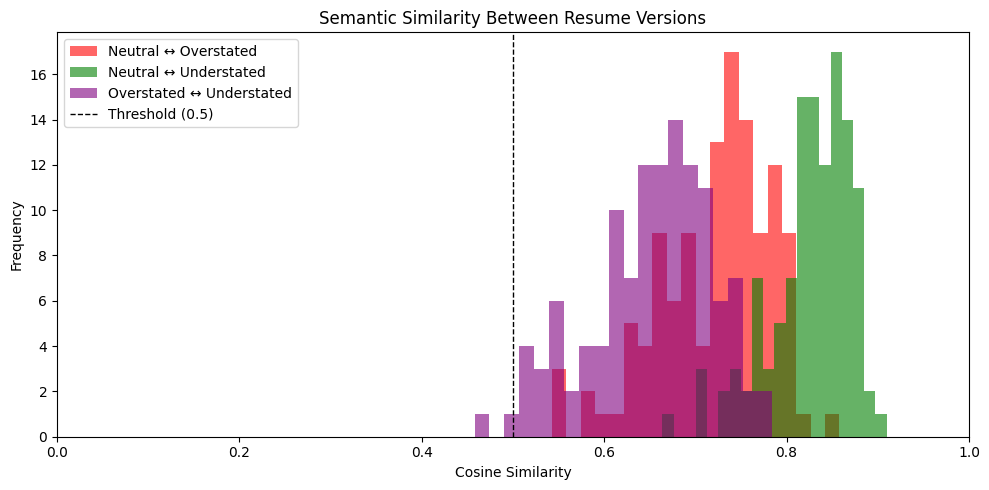

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(neutral_overstated, bins=20, alpha=0.6, label='Neutral ↔ Overstated', color='red')
ax.hist(neutral_understated, bins=20, alpha=0.6, label='Neutral ↔ Understated', color='green')
ax.hist(overstated_understated, bins=20, alpha=0.6, label='Overstated ↔ Understated', color='purple')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Threshold (0.5)')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Semantic Similarity Between Resume Versions')
ax.legend()
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

### Graph Analysis

The histogram shows the distribution of semantic similarity scores between resume versions:

- **Neutral ↔ Overstated (Red)**: Should cluster in high similarity range (0.6-0.9), indicating overstated versions preserve the original content while adding power words.

- **Neutral ↔ Understated (Green)**: Should also show high similarity, confirming understated versions keep the same experiences but use humble language.

- **Overstated ↔ Understated (Purple)**: Expected to have slightly lower similarity since these are the most different in tone, but still sharing core content.

**Key Observation**: All distributions are above the 0.5 threshold line, confirming the LLM successfully changed tone without inventing new content or removing real experiences.

In [5]:
# Check similarity by seniority level
print("SIMILARITY BY SENIORITY LEVEL")
print("-" * 60)
print(f"{'Seniority':<12} {'N↔O Mean':<15} {'N↔U Mean':<15} {'O↔U Mean':<15}")
print("-" * 60)

for seniority in ['junior', 'mid', 'senior']:
    mask = df['seniority'] == seniority
    indices = df[mask].index.tolist()
    
    no_mean = np.mean([neutral_overstated[i] for i in indices])
    nu_mean = np.mean([neutral_understated[i] for i in indices])
    ou_mean = np.mean([overstated_understated[i] for i in indices])
    
    print(f"{seniority:<12} {no_mean:.3f}{'':>10} {nu_mean:.3f}{'':>10} {ou_mean:.3f}")

SIMILARITY BY SENIORITY LEVEL
------------------------------------------------------------
Seniority    N↔O Mean        N↔U Mean        O↔U Mean       
------------------------------------------------------------
junior       0.665           0.824           0.611
mid          0.748           0.843           0.680
senior       0.752           0.812           0.664


---

## Findings Summary

### What This Metric Validates

Semantic similarity confirms that the three resume versions (neutral, overstated, understated) describe the **same person with the same experience** - only the language style differs.

High similarity scores (>0.5) mean:
- The LLM did not invent fake achievements for overstated versions
- The LLM did not remove real experiences from understated versions
- All three versions are valid representations of the same candidate

### Why This Matters for Testing

When we test model predictions, we need to be certain that any difference in seniority prediction between versions is due to **language style bias**, not because the content actually changed.

If an overstated junior resume gets predicted as senior while its neutral version gets predicted as junior, we can confidently say the model was influenced by **how** the candidate wrote, not **what** they wrote.